----
----
-----
-------


## **DropBlock, eğitim sırasında CNN’in her forward pass’te ürettiği feature map’ler üzerinde rastgele k×k blokları sıfırlayan bir regularization yöntemidir; sadece train modunda çalışır, inference’ta devre dışıdır.**

---
-----
--------
-------

# DropBlock (CNN Regularization)

**Amaç:** CNN'lerde klasik Dropout'un sınırlı kaldığı yerde, uzamsal (spatial) korelasyonları hedefleyerek genellemeyi (generalization) artıran **DropBlock** yöntemini temelden derine doğru anlatmak.

> Not: Bu not, teori + pratik (PyTorch implementasyonu, görselleştirme, kullanım ipuçları) şeklinde ilerler.


## 1) Regularization nedir?

Derin ağlar, özellikle veri azsa veya model kapasitesi fazlaysa **overfitting** yapabilir: eğitim setinde çok iyi, testte zayıf.

**Regularization** teknikleri, modelin gereksiz ayrıntıları ezberlemesini engelleyip daha genel kalıpları öğrenmesine yardım eder.

CNN tarafında regularization çoğunlukla şu yollardan gelir:
- **Parametre cezası:** weight decay (L2)
- **Stokastik yapı:** Dropout ailesi (Dropout, DropBlock, DropPath)
- **Veri tarafı:** Cutout / Augmentation (mask, crop, jitter)

Bu defterin odağı: **DropBlock**.


## 2) Klasik Dropout CNN'de neden bazen zayıf kalır?

Klasik Dropout, aktivasyonların bazılarını **bağımsız** biçimde (i.i.d) sıfırlar.

Fakat CNN feature map'lerinde komşu pikseller/aktivasyonlar genelde **yüksek korelasyonlu** olur.
- Bir aktivasyon düşse bile yanındaki benzer aktivasyonlar kaldığı için bilgi akışı devam eder.
- Özellikle erken/orta katmanlarda bu durum daha belirgindir.

Sonuç: Klasik Dropout, CNN'de bazen beklenen kadar güçlü regularization üretmez.


## 3) DropBlock nedir?

**DropBlock**, CNN feature map'leri üzerinde tek tek noktaları değil, **bitişik blokları** (contiguous regions) düşüren bir dropout varyantıdır.

### Temel fikir
- Klasik Dropout: rastgele **tekil** aktivasyonlar düşer.
- DropBlock: rastgele seçilen merkezlerin etrafında **k×k blok** halinde maskelenir.

Bu sayede model, yalnızca küçük lokal ipuçlarına yaslanmak yerine daha geniş bağlamı kullanmaya zorlanır.


## 4) DropBlock hangi problemi çözer?

DropBlock, şu problemi hedefler:

### Problem
CNN feature map'lerinde **uzamsal korelasyon** çok yüksek → i.i.d dropout etkisi azalıyor.

### Çözüm
Aktivasyonları **blok halinde** düşür → lokal korelasyonu doğrudan hedef al → daha güçlü regularization.

Özellikle:
- Derin CNN'ler
- Sınırlı veri
- Overfitting eğilimi
- Büyük receptive field'e rağmen lokal shortcut öğrenme

senaryolarında faydalı olur.


## 5) DropBlock nasıl çalışır?

DropBlock'ı iki adımda düşünebilirsin:

1. **Merkez maskesi** üret: her konum için belirli olasılıkla (γ) 'bu nokta blok merkezi olsun' diye seç.
2. Seçilen her merkezin etrafında **k×k** bölgeyi sıfırla.

Bu işlem sonunda bir **block mask** oluşur ve feature map şu şekilde uygulanır:

\[
y = x \odot m \cdot \frac{1}{\text{keep\_ratio}}
\]

- \(m\): {0,1} maske
- keep_ratio: beklenen aktivasyon korunma oranı (ölçekleme için)

Bu ölçekleme, Dropout'taki gibi beklenen aktivasyon büyüklüğünü korumak içindir.


## 6) γ (gamma) nedir? Neden gerekir?

DropBlock'ta istenen şey şudur:
- 'Toplamda p kadar aktivasyon düşsün' (drop_prob = p)
- ama bu düşüş **blok halinde** olsun.

Blok boyutu büyüdükçe, aynı drop_prob için merkez seçme olasılığı (γ) daha küçük olmalıdır.

Pratikte yaygın kullanılan bir yaklaşım:

\[
\gamma = \frac{p \cdot H \cdot W}{k^2 \cdot (H-k+1)(W-k+1)}
\]

- H, W: feature map'in yüksekliği/genişliği
- k: block_size
- p: drop_prob

Bu formül, blok merkezlerinin seçileceği **geçerli alanı** ve blok alanını dikkate alır.

> Not: Literatürde farklı varyantlar görülebilir; bu form pratikte çok kullanılan, iyi çalışan bir seçenektir.


In [1]:
# Kurulum / import
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(42)


## 7) PyTorch ile DropBlock2D implementasyonu

Aşağıdaki sınıf:
- `drop_prob`: düşürme olasılığı (p)
- `block_size`: blok boyutu (k)
- sadece **train** modunda çalışır (`model.train()`)

Uygulama adımları:
1. γ hesapla
2. Bernoulli ile merkez maskesi üret
3. MaxPool ile merkezleri k×k bloğa genişlet
4. Maskeyi uygula ve keep_ratio ile ölçekle


In [ ]:
class DropBlock2D(nn.Module):
    def __init__(self, drop_prob: float = 0.1, block_size: int = 7):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.block_size = int(block_size)

    def _compute_gamma(self, x: torch.Tensor) -> float:
        # x: [N, C, H, W]
        _, _, H, W = x.shape
        k = self.block_size
        p = self.drop_prob

        if k <= 0:
            raise ValueError("block_size >= 1 olmalı.")
        if k > H or k > W:
            # Çok büyük blok: pratikte ya kapatılır ya da k küçültülür
            return 0.0

        # Yaygın pratik gamma formülü
        gamma = (p * H * W) / (k * k * (H - k + 1) * (W - k + 1))
        return float(gamma)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if (not self.training) or self.drop_prob <= 0.0:
            return x

        N, C, H, W = x.shape
        k = self.block_size
        gamma = self._compute_gamma(x)

        if gamma <= 0.0:
            return x

        # Merkez maskesi: [N, 1, H, W] (channel bağımsız)
        center_mask = torch.empty((N, 1, H, W), device=x.device, dtype=x.dtype).bernoulli_(gamma)

        # Center -> Block mask: maxpool ile genişlet
        # padding = k//2 ile "yaklaşık" merkezleme (k tek olmalı tercih edilir)
        pad = k // 2
        block_mask = F.max_pool2d(center_mask, kernel_size=k, stride=1, padding=pad)

        # maxpool çıktısı 0/1 -> blokların içi 1 olur. Düşürmek için tersle.
        block_mask = 1.0 - block_mask  # 1: keep, 0: drop

        # Eğer k çiftse boyut kayması olabilir, güvenli kırpma:
        block_mask = block_mask[..., :H, :W]

        # Keep ratio ile ölçekle (beklenen aktivasyon büyüklüğü sabit kalsın)
        keep_ratio = block_mask.mean().clamp(min=1e-6)
        y = x * block_mask * (1.0 / keep_ratio)
        return y

## 8) Hızlı sanity check

Beklenti:
- train modunda maske uygular
- eval modunda aynı input'u değiştirmez
- ölçekleme sayesinde output ortalaması dramatik sapmaz


In [3]:
db = DropBlock2D(drop_prob=0.2, block_size=5)

x = torch.randn(2, 3, 16, 16)

db.train()
y_train = db(x)

db.eval()
y_eval = db(x)

print("x mean:", x.mean().item())
print("train mean:", y_train.mean().item())
print("eval mean:", y_eval.mean().item())
print("eval diff:", (y_eval - x).abs().max().item())


x mean: 0.004229326266795397
train mean: 0.004957688506692648
eval mean: 0.004229326266795397
eval diff: 0.0


## 9) Maske görselleştirme (Dropout vs DropBlock fikri)

Aşağıda DropBlock maskesi tek bir örnek üzerinde çizdirilir.
- Beyaz (1): korunuyor
- Siyah (0): düşürülüyor


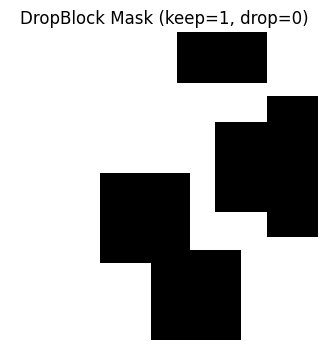

In [4]:
def get_dropblock_mask(H=24, W=24, drop_prob=0.2, block_size=7, seed=0):
    torch.manual_seed(seed)
    tmp = DropBlock2D(drop_prob=drop_prob, block_size=block_size)
    tmp.train()
    x = torch.ones(1, 1, H, W)
    with torch.no_grad():
        # DropBlock2D içinde maske private değil; çıktıdan maskeyi geri çıkaralım:
        y = tmp(x)
        # x=1 olduğu için y ya 0 ya ölçekli 1 => maskeyi yaklaşık elde ederiz
        # ölçek etkisini kaldırmak için: 0 olanlar drop; >0 olanlar keep
        mask = (y > 0).float()[0, 0]
    return mask.cpu()

mask = get_dropblock_mask(H=24, W=24, drop_prob=0.25, block_size=7, seed=42)

plt.figure(figsize=(4,4))
plt.imshow(mask, interpolation="nearest", cmap="gray")
plt.title("DropBlock Mask (keep=1, drop=0)")
plt.axis("off")
plt.show()


## 10) DropBlock nerede konumlandırılır?

Pratikte en sık görülen yerleşimler:
- Conv/Norm/Act bloklarından sonra
- Residual block içinde (özellikle son conv çıkışına yakın)
- Çok erken katmanlarda agresif kullanmak bazen zarar verebilir (detay kaybı)

Genel kural:
- **Orta / derin** katmanlarda daha mantıklı
- `block_size` feature map boyutuna göre ayarlanmalı

Örnek: 56×56 feature map'te k=7 mantıklı olabilir.
14×14 feature map'te k=7 aşırı agresif olabilir.


## 11) DropBlock için pratik hiperparametre ipuçları

**drop_prob (p)**
- Başlangıç: 0.05–0.15
- Overfit belirginse: 0.2–0.3'e çıkılabilir

**block_size (k)**
- Feature map boyutuna bağlı
- Kural gibi: k, H/W'nin ~%10–%30'u civarı denenebilir

**schedule (önerilir)**
- Eğitim başında düşük p, sonlara doğru yükseltmek iyi çalışır.
- Çünkü model önce temel temsilleri kurar, sonra regularization sertleşir.


In [ ]:
class LinearScheduler:
    """drop_prob'u epoch ile lineer artırmak için basit scheduler."""
    def __init__(self, module: DropBlock2D, start_p=0.0, stop_p=0.2, nr_steps=100):
        self.module = module
        self.start_p = float(start_p)
        self.stop_p = float(stop_p)
        self.nr_steps = int(nr_steps)
        self.step_id = 0

    def step(self):
        t = min(self.step_id / max(1, self.nr_steps), 1.0)
        p = self.start_p + t * (self.stop_p - self.start_p)
        self.module.drop_prob = float(p)
        self.step_id += 1
        return p

## 12) Mini CNN örneği: DropBlock entegrasyonu

Aşağıdaki küçük modelde DropBlock, conv blokları arasında kullanılır.

Amaç: entegrasyonun nasıl göründüğünü göstermek.


In [6]:
class ConvBNAct(nn.Module):
    def __init__(self, cin, cout, k=3, s=1, p=1, act='relu'):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, k, stride=s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(cout)
        self.act = nn.ReLU(inplace=True) if act == 'relu' else nn.SiLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class TinyCNNWithDropBlock(nn.Module):
    def __init__(self, num_classes=10, drop_prob=0.1, block_size=5):
        super().__init__()
        self.stem = ConvBNAct(3, 32, k=3, s=1, p=1)
        self.block1 = nn.Sequential(
            ConvBNAct(32, 64, k=3, s=2, p=1),
            DropBlock2D(drop_prob=drop_prob, block_size=block_size),
            ConvBNAct(64, 64, k=3, s=1, p=1),
        )
        self.block2 = nn.Sequential(
            ConvBNAct(64, 128, k=3, s=2, p=1),
            DropBlock2D(drop_prob=drop_prob, block_size=block_size),
            ConvBNAct(128, 128, k=3, s=1, p=1),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

m = TinyCNNWithDropBlock(num_classes=10, drop_prob=0.15, block_size=5)
print(m)


TinyCNNWithDropBlock(
  (stem): ConvBNAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU(inplace=True)
  )
  (block1): Sequential(
    (0): ConvBNAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (1): DropBlock2D()
    (2): ConvBNAct(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
  )
  (block2): Sequential(
    (0): ConvBNAct(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

## 13) DropBlock ne zaman iyi çalışmayabilir?

Aşağıdaki durumlarda dikkat:
- Feature map çok küçükken büyük block_size (örn 7×7 feature map ve k=7)
- Zaten ağır regularization + çok az kapasite → underfitting
- Veri zaten çok büyük ve güçlü augmentation varsa → katkısı az olabilir

İyi pratik:
- `block_size`'ı stage'e göre ayarla (derine indikçe küçült)
- `drop_prob` için schedule kullan


## 14) Kısa özet

- DropBlock, CNN'lerde i.i.d Dropout'un zayıfladığı **uzamsal korelasyon** problemini hedefler.
- Aktivasyonları tek tek değil, **bitişik bloklar** halinde düşürür.
- `drop_prob` ve `block_size` doğru ayarlanırsa genellemeyi artırabilir.
- En iyi sonuçlar genelde **orta/derin** katmanlarda ve **schedule** ile gelir.
